In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv('Datasets/adult.csv')

In [3]:
df.head()
df = df.drop("education.num", axis = 1)
target = df["income"]
data = df.drop("income", axis = 1)

In [32]:
#notice there are null attributes but we'll build our pipelines to ignore these Null inputs
from sklearn import set_config
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting# this line is required to import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split


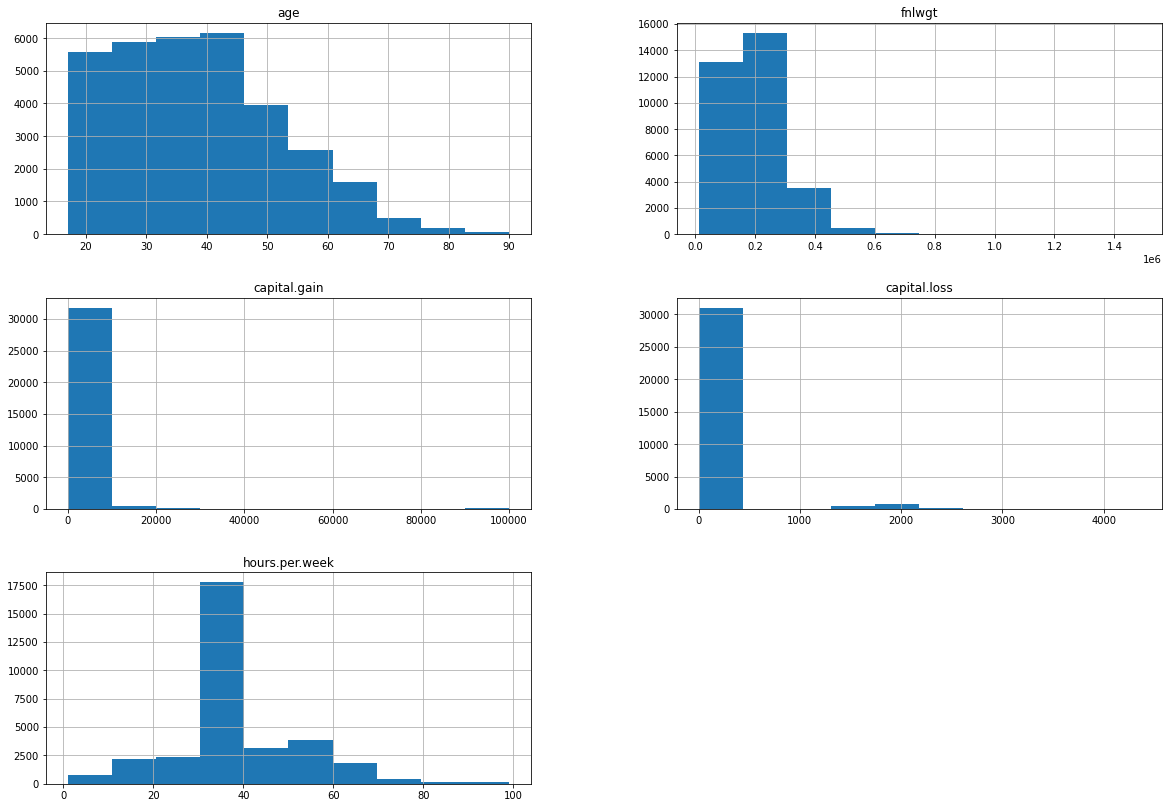

In [33]:
_=df.hist(figsize=(20, 14))

In [45]:
categorical_preprocessor = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
categorical_columns_selector = selector(dtype_include = object)
categorical_columns = categorical_columns_selector(data)

In [46]:
processor = ColumnTransformer([("categorical", categorical_preprocessor, categorical_columns)],
                              remainder = "passthrough", sparse_threshold = 0)

In [47]:
model = Pipeline([("Preprocessor", processor), ("classifier",HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])

In [48]:
set_config(display = "diagram")
model

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

The loguniform function from SciPy returns a floating number. Since we want to us this distribution to create integer, we will create a class that will cast the floating number into an integer.

In [49]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [50]:
#note we use Pipeline() instead of make_pipeline()
param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255)}


Random search (with RandomizedSearchCV) is typically beneficial compared to grid search (with GridSearchCV) to optimize 3 or more hyperparameters.

In [51]:
model_random_search = RandomizedSearchCV(model, param_distributions, n_iter = 10, n_jobs =4, cv = 5)

data_train, data_test,target_train,  target_test = train_test_split(data, target)

In [52]:
model_random_search.fit(data_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('categorical',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital.status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native.country'])])),
                                             ('classifier',
                                              HistGra...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000181AEF59A88>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000181AEF593C8>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x00000181ADD09808>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x00000181AEF59A08>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x00000181ADD7F188>})

In [53]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is {accuracy:.2f}")

The test accuracy score of the best model is 0.86


In [54]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 0.0009936552304617196,
 'classifier__learning_rate': 0.09018313394228086,
 'classifier__max_bins': 139,
 'classifier__max_leaf_nodes': 4,
 'classifier__min_samples_leaf': 1}


In [55]:
#getting the names of the parameters

column_results = [f"param_{name}" for name in param_distributions.keys()]

In [56]:
print(column_results)

['param_classifier__l2_regularization', 'param_classifier__learning_rate', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__max_bins']


In [58]:
 column_results+=["mean_test_score", "std_test_score", "rank_test_score"]

In [60]:
cv_results = pd.DataFrame(model_random_search.cv_results_) #we use cv_results_
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_bins,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.897438,0.068469,0.099734,0.009097,1.281954,0.171467,19,13,4,{'classifier__l2_regularization': 1.2819539290...,0.857289,0.860770,0.853808,0.855651,0.859132,0.857330,0.002462,2
1,2.893575,0.225854,0.155185,0.022261,166.776832,0.136225,22,90,18,{'classifier__l2_regularization': 166.77683207...,0.860360,0.860565,0.854218,0.851351,0.857289,0.856757,0.003562,3
2,0.338627,0.031363,0.043480,0.005069,444.855673,6.110655,100,53,47,{'classifier__l2_regularization': 444.85567281...,0.805487,0.797297,0.791769,0.782760,0.788288,0.793120,0.007783,8
3,0.845934,0.088777,0.117535,0.021209,0.000104,0.0028,46,8,1,{'classifier__l2_regularization': 0.0001042123...,0.756552,0.756552,0.756347,0.756347,0.756347,0.756429,0.000100,9
4,1.160207,0.074235,0.134776,0.007755,0.00003,0.043258,4,7,74,{'classifier__l2_regularization': 3.0435008909...,0.813882,0.814496,0.803030,0.814496,0.808559,0.810893,0.004520,7
5,1.071344,0.012757,0.141893,0.006196,869.476177,0.124682,55,5,55,{'classifier__l2_regularization': 869.47617704...,0.852989,0.854832,0.844595,0.848075,0.850737,0.850246,0.003618,6
6,1.723042,0.171188,0.099943,0.007592,0.042732,0.119694,17,102,89,{'classifier__l2_regularization': 0.0427318163...,0.857289,0.859337,0.848280,0.846642,0.857903,0.853890,0.005317,5
7,1.011401,0.051225,0.115094,0.005832,0.00003,0.001251,186,15,7,{'classifier__l2_regularization': 3.0041304264...,0.756552,0.756552,0.756347,0.756347,0.756347,0.756429,0.000100,9
8,0.586598,0.053945,0.072442,0.012383,0.000303,0.395964,38,2,12,{'classifier__l2_regularization': 0.0003033993...,0.855856,0.857289,0.850942,0.855242,0.855856,0.855037,0.002155,4
9,0.674144,0.036813,0.086657,0.012187,0.000994,0.090183,139,4,1,{'classifier__l2_regularization': 0.0009936552...,0.861179,0.861998,0.854423,0.859132,0.859541,0.859255,0.002634,1


In [63]:
cv_results = cv_results[column_results].sort_values(by ="mean_test_score", ascending = False)
cv_results

,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,param_classifier__max_bins,mean_test_score,std_test_score,rank_test_score
9,0.000994,0.090183,4,1,139,0.859255,0.002634,1
0,1.281954,0.171467,13,4,19,0.857330,0.002462,2
1,166.776832,0.136225,90,18,22,0.856757,0.003562,3
8,0.000303,0.395964,2,12,38,0.855037,0.002155,4
6,0.042732,0.119694,102,89,17,0.853890,0.005317,5
5,869.476177,0.124682,5,55,55,0.850246,0.003618,6
4,0.00003,0.043258,7,74,4,0.810893,0.004520,7
2,444.855673,6.110655,53,47,100,0.793120,0.007783,8
3,0.000104,0.0028,8,1,46,0.756429,0.000100,9
7,0.00003,0.001251,15,7,186,0.756429,0.000100,9


In [70]:
#now we need to eliminate elements before "__"
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__",1)[1]
    return param_name

In [71]:
#shortening of names
cv_results = cv_results.rename(shorten_param, axis = 1) #renaming all the columns
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
9,0.000994,0.090183,4,1,139,0.859255,0.002634,1
0,1.281954,0.171467,13,4,19,0.857330,0.002462,2
1,166.776832,0.136225,90,18,22,0.856757,0.003562,3
8,0.000303,0.395964,2,12,38,0.855037,0.002155,4
6,0.042732,0.119694,102,89,17,0.853890,0.005317,5
5,869.476177,0.124682,5,55,55,0.850246,0.003618,6
4,0.00003,0.043258,7,74,4,0.810893,0.004520,7
2,444.855673,6.110655,53,47,100,0.793120,0.007783,8
3,0.000104,0.0028,8,1,46,0.756429,0.000100,9
7,0.00003,0.001251,15,7,186,0.756429,0.000100,9


## The making of a pre trained model

In [76]:
%%time
#from tqdm import tqdm

model_random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=500,
                                         n_jobs=4, cv=5)
model_random_search.fit(data_train, target_train)
cv_results =  pd.DataFrame(model_random_search.cv_results_)
cv_results.to_csv("../randomized_search_results.csv")

Wall time: 8min 35s


## Using the pre trained model

In [78]:
cv_results = pd.read_csv("../randomized_search_results.csv",index_col=0)

In [88]:
cv_results =cv_results[column_results].rename(shorten_param, axis=1).sort_values(by ="mean_test_score")

In [98]:
import numpy as np
import plotly.express as px

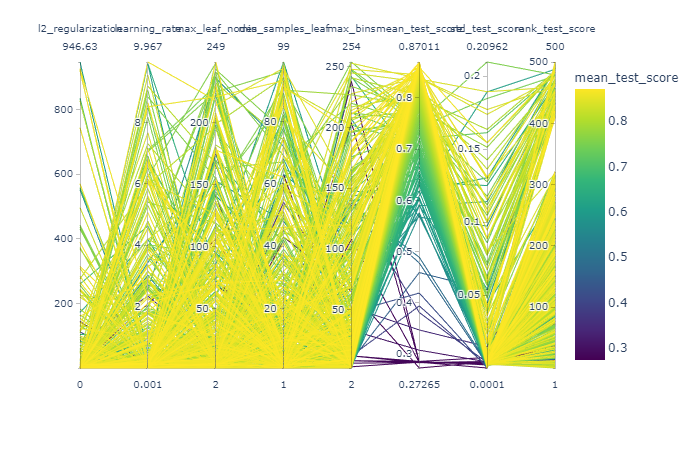

<Figure size 1152x1152 with 0 Axes>

In [107]:
fig = px.parallel_coordinates(
        cv_results, color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis)

fig.show("png")
#unclear

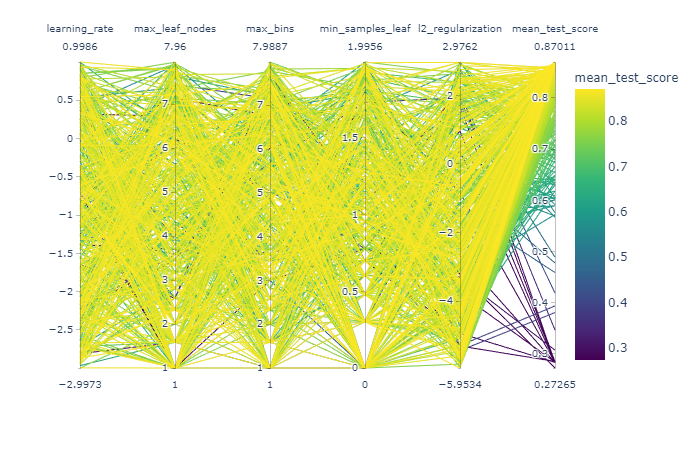

In [108]:
#scaling
fig = px.parallel_coordinates(
    cv_results.rename(shorten_param, axis=1).apply({
        "learning_rate": np.log10,
        "max_leaf_nodes": np.log2,
        "max_bins": np.log2,
        "min_samples_leaf": np.log10,
        "l2_regularization": np.log10,
        "mean_test_score": lambda x: x}),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show("png")

# End